In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import xgboost as xgb
import optuna
import sklearn.metrics

# Data treatment

In [3]:
train_raw = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [4]:
train_df=train_raw

In [5]:
train_labels = train_raw['Transported']
train_df[['CabinDeck', 'CabinNum', 'CabinSide']] = train_df['Cabin'].str.split('/', n=2, expand=True)
train_df = pd.concat([train_df,pd.get_dummies(train_df.Destination)], axis = 1)
train_df = train_df.drop(['Name','Destination','Cabin'],axis=1)
train_df.dropna(inplace=True)

train_df['CryoSleep'] = train_df['CryoSleep'].astype(bool)
train_df['VIP'] = train_df['VIP'].astype(bool)
train_df['CabinSide'] = train_df['CabinSide'].replace({'S': 0, 'P': 1})
train_df['CabinNum'] = train_df['CabinNum'].astype(int)
train_df['CabinDeck'] = train_df['CabinSide'].replace(
    {'A': 0,
     'B': 1,
     'C': 2,
     'D': 3,
     'E': 4,
     'F': 5,
     'G': 6,
     'T': 7
    })
train_df['HomePlanet'] = train_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})

/tmp/ipykernel_18/2362847667.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['CabinSide'] = train_df['CabinSide'].replace({'S': 0, 'P': 1})
/tmp/ipykernel_18/2362847667.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['HomePlanet'] = train_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})


In [6]:
#train_df[train_df['HomePlanet'].isnull()]
#df1 = train_df[train_df.isna().any(axis=1)]

In [7]:
train_df

,PassengerId,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinNum,CabinSide,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0001_01,0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0,1,False,False,True
1,0002_01,1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,0,False,False,True
2,0003_01,0,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0,0,False,False,True
3,0003_02,0,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0,0,False,False,True
4,0004_01,1,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,1,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,98,1,True,False,False
8689,9278_01,1,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,1499,0,False,True,False
8690,9279_01,1,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0,1500,0,False,False,True
8691,9280_01,0,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,0,608,0,True,False,False


# Dataset Split

In [8]:
def split_dataset(dataset, test_ratio=0.25):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [9]:
dft, dfv = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(dft), len(dfv)))

5145 examples in training, 1768 examples in testing.


In [10]:
y= dft['Transported']
Y=dfv['Transported']
x = dfv.drop(['Transported','PassengerId'],axis=1)
X=dft.drop(['Transported','PassengerId'],axis=1)

# Optuna HP Tuning

In [11]:
dtrain = xgb.DMatrix(X, label=dft['Transported'])
dvalid = xgb.DMatrix(x, label=dfv['Transported'])

def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    param = {
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth',1, 100),
        'max_leaves': trial.suggest_int('max_depth',1, 100),
        'n_estimators': trial.suggest_int('n_estimators',1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True)
    }    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(dfv['Transported'], pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-03-08 04:03:08,778] A new study created in memory with name: no-name-cdbccf61-fba8-4f33-9450-128f22c32c23
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:03:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-08 04:03:08,841] Trial 0 finished with value: 0.49095022624434387 and parameters: {'booster': 'dart', 'gamma': 2.0341797678305787e-07, 'max_depth': 6, 'n_estimators': 35, 'grow_policy': 'lossguide', 'learning_rate': 1.7106485684639066e-08}. Best is trial 0 with value: 0.49095022624434387.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:03:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-08 04:03:08,857] Trial 1 finished with value: 0.49095022624434387 and parameters: {'booster': 'gbtree', 'gamma': 1.1765349881902577e-06, 'max_depth': 4, 'n_esti

# Model

In [12]:
model = xgb.XGBRFClassifier(
    booster='gbtree',
    device='cpu',
    eval_metric=sklearn.metrics.mean_absolute_percentage_error,
    grow_policy = 'lossguide',
    gamma = 0.030185106394347308,
    max_depth= 5,
    n_estimators = 93,
    learning_rate = 0.571705231643359
)

In [13]:
model.fit(X,y,eval_set=[(X,y),(x,Y)])

[0]	validation_0-logloss:0.51376	validation_0-mean_absolute_percentage_error:869371106820096.00000	validation_1-logloss:0.52386	validation_1-mean_absolute_percentage_error:913133401014272.00000


XGBRFClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device='cpu',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=<function mean_absolute_percentage_error at 0x7ec08f006290>,
                feature_types=None, gamma=0.030185106394347308,
                grow_policy='lossguide', importance_type=None,
                interaction_constraints=None, learning_rate=0.571705231643359,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=93, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [14]:
trueval = dfv['Transported']
predval = model.predict(x)
sklearn.metrics.accuracy_score(trueval, predval)

0.7861990950226244

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

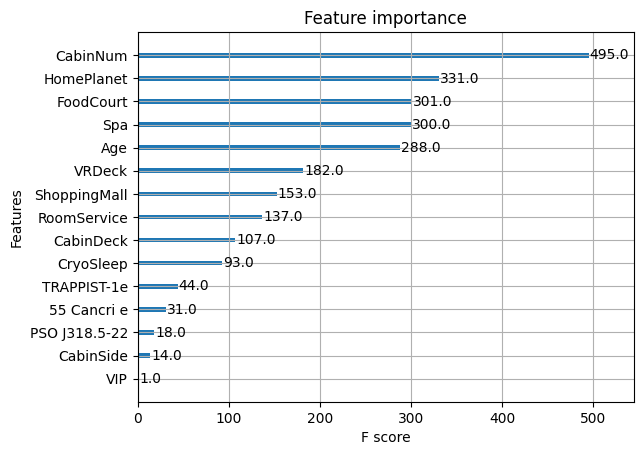

In [15]:
xgb.plot_importance(model)

# Prediction

In [16]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
labels = test_df['PassengerId']

In [17]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [18]:
test_df[['CabinDeck', 'CabinNum', 'CabinSide']] = test_df['Cabin'].str.split('/', n=2, expand=True)
test_df = pd.concat([test_df,pd.get_dummies(test_df.Destination)], axis = 1)
test_df = test_df.drop(['Name','Destination','Cabin','PassengerId'],axis=1)
test_df.fillna(0,inplace=True)

test_df['CryoSleep'] = test_df['CryoSleep'].astype(bool)
test_df['VIP'] = test_df['VIP'].astype(bool)
test_df['CabinSide'] = test_df['CabinSide'].replace({'S': 0, 'P': 1})
test_df['CabinNum'] = test_df['CabinNum'].astype(int)
test_df['CabinDeck'] = test_df['CabinSide'].replace(
    {'A': 0,
     'B': 1,
     'C': 2,
     'D': 3,
     'E': 4,
     'F': 5,
     'G': 6,
     'T': 7
    })
test_df['HomePlanet'] = test_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})

/tmp/ipykernel_18/17557714.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['CabinSide'] = test_df['CabinSide'].replace({'S': 0, 'P': 1})
/tmp/ipykernel_18/17557714.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['HomePlanet'] = test_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})


In [19]:
test_df

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,1,True,27.0,False,0.0,0.0,0.0,0.0,0.0,0,3,0,False,False,True
1,1,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,4,0,False,False,True
2,0,True,31.0,False,0.0,0.0,0.0,0.0,0.0,0,0,0,True,False,False
3,0,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,0,1,0,False,False,True
4,1,False,20.0,False,10.0,0.0,635.0,0.0,0.0,0,5,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,True,34.0,False,0.0,0.0,0.0,0.0,0.0,0,1496,0,False,False,True
4273,1,False,42.0,False,0.0,847.0,17.0,10.0,144.0,0,0,0,False,False,True
4274,2,True,0.0,False,0.0,0.0,0.0,0.0,0.0,1,296,1,True,False,False
4275,0,False,0.0,False,0.0,2680.0,0.0,0.0,523.0,1,297,1,False,False,False


In [20]:
test_df['Transported'] = model.predict(test_df)
test_df['PassengerId'] = labels
dfexport = test_df[['PassengerId','Transported']]
dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True})

/tmp/ipykernel_18/2563146156.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True})
/tmp/ipykernel_18/2563146156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True})


In [21]:
dfexport

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [22]:
dfexport.to_csv('predictionoutput2.csv')

In [23]:
# The fillna method is trash